In [4]:
import json
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt


In [14]:


class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = self.values(values)  # (N, value_len, embed_size)
        keys = self.keys(keys)  # (N, key_len, embed_size)
        queries = self.queries(query)  # (N, query_len, embed_size)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out


class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out


class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

        return out


class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cpu",
        max_length=100,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out


In [15]:
class PacketTokenizer:
    def __init__(self):
        self.token_to_id = {}
        self.id_to_token = {}

    def build_vocab(self, packets):
        tokens = set()
        for packet in packets:
            for key, value in packet.items():
                tokens.add(f"{key}:{value}")
        for idx, token in enumerate(sorted(tokens)):
            self.token_to_id[token] = idx
            self.id_to_token[idx] = token

    def encode(self, packet):
        return [self.token_to_id[f"{key}:{value}"] for key, value in packet.items()]

    def decode(self, token_ids):
        return [self.id_to_token[token_id] for token_id in token_ids]


In [16]:
# Load the packets.json file
with open("packets.json", "r") as f:
    packets = json.load(f)

# Initialize the tokenizer and build vocabulary
tokenizer = PacketTokenizer()
tokenizer.build_vocab(packets)

# Tokenize the packets
for packet in packets:
    tokenized_packets = tokenizer.encode(packet)
    print(tokenized_packets)

# Print an example of tokenized data
print("Tokenized Packets:", tokenized_packets[:2])


Tokenized Packets: [[132, 2, 124, 133, 20, 205, 91, 120], [129, 5, 124, 138, 18, 205, 91, 111]]


In [17]:
# Pad sequences
max_length = 10  # Adjust based on the sequence length you want
padded_packets = pad_sequence(
    [torch.tensor(packet) for packet in tokenized_packets],
    batch_first=True,
    padding_value=0
)

# Randomly create target sequences by shifting source sequences
trg = torch.roll(padded_packets, shifts=1, dims=0)

# Define a simple dataset class
class PacketDataset(Dataset):
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.trg[idx]

# Create a DataLoader
dataset = PacketDataset(padded_packets, trg)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [18]:

# Parameters
src_vocab_size = len(tokenizer.token_to_id)
trg_vocab_size = len(tokenizer.token_to_id)
src_pad_idx = 0
trg_pad_idx = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = Transformer(
    src_vocab_size=src_vocab_size,
    trg_vocab_size=trg_vocab_size,
    src_pad_idx=src_pad_idx,
    trg_pad_idx=trg_pad_idx,
    embed_size=128,
    num_layers=2,
    forward_expansion=2,
    heads=2,
    dropout=0.1,
    device=device,
    max_length=max_length,
).to(device)


In [19]:
# Get a batch of data
for src, trg in dataloader:
    src, trg = src.to(device), trg.to(device)
    trg_input = trg[:, :-1]
    trg_expected = trg[:, 1:]

    # Forward pass
    out = model(src, trg_input)

    print("Output shape:", out.shape)  # Should be (batch_size, seq_len, vocab_size)
    break


Output shape: torch.Size([2, 7, 245])


In [20]:
criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Compute loss
out = out.reshape(-1, out.shape[2])  # Flatten batch and sequence dimensions
trg_expected = trg_expected.reshape(-1)

loss = criterion(out, trg_expected)
print("Loss:", loss.item())

# Backpropagate
loss.backward()
optimizer.step()


Loss: 5.557058811187744


Epoch 1, Loss: 0.7513054609298706
Epoch 2, Loss: 0.31142857670783997
Epoch 3, Loss: 0.09683062881231308
Epoch 4, Loss: 0.4229430556297302
Epoch 5, Loss: 0.2587588429450989


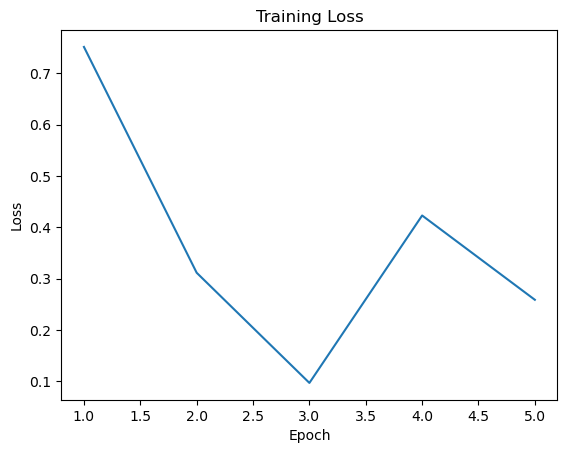

In [21]:
# Example training loop
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    for src, trg in dataloader:
        src, trg = src.to(device), trg.to(device)
        trg_input = trg[:, :-1]
        trg_expected = trg[:, 1:]

        optimizer.zero_grad()
        out = model(src, trg_input)

        out = out.reshape(-1, out.shape[2])
        trg_expected = trg_expected.reshape(-1)

        loss = criterion(out, trg_expected)
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Plot loss curve
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


In [3]:
# Get predictions
predicted_tokens = torch.argmax(out, dim=1).view(trg_input.shape)
for tokens in predicted_tokens:
    print("Decoded Packet:", tokenizer.decode(tokens.tolist()))

NameError: name 'out' is not defined